In [2]:
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# gt_disc_file_name = "gt_experiments_20250730_220734.csv"
# df = pd.read_csv("../src/gt_evaluation/" + gt_disc_file_name)
gt_nodisc_file_name = "gt_experiments_20250730_214409.csv"
df = pd.read_csv(gt_nodisc_file_name)
df.trajectory = df.trajectory.apply(lambda x: ast.literal_eval(x))

In [4]:
df.shape

(40, 16)

In [5]:
df.n_manufacturers.value_counts()

n_manufacturers
2    15
3    10
5     8
4     2
8     2
6     2
7     1
Name: count, dtype: int64

In [6]:
bins   = [0, 2, 3, 5, 10]                 # interval edges
labels = ["2", "3", "(3,5]", "(5,10]"]    # what each bucket is called

df["manufacturers"] = pd.cut(
    df["n_manufacturers"],
    bins=bins,
    labels=labels,
    right=True,        # right edge is inclusive → 2 → “2”, 3 → “3”, 5 → “(3,5]”
    include_lowest=False
)

In [7]:
df.manufacturers.value_counts()

manufacturers
2         15
3         10
(3,5]     10
(5,10]     5
Name: count, dtype: int64

In [8]:
df["intensity"] = df["fda_interventions"] / df["periods"]
# then take the mean within each manufacturer-size bucket
avg_intensity_by_mfr_bin = (
    df.groupby("manufacturers")["intensity"]
      .mean()
      .sort_index()          # optional, keeps bins in order 2, 3, (3,5], (5,10]
)

print(avg_intensity_by_mfr_bin)

manufacturers
2         0.385370
3         0.239881
(3,5]     0.466667
(5,10]    0.430000
Name: intensity, dtype: float64


/var/folders/33/gyvvd4710r7_4n22mnftfz4h0000gn/T/ipykernel_54491/2862319885.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("manufacturers")["intensity"]


In [9]:
tmp = df.explode('trajectory', ignore_index=True)
sim_cols = (
    pd.json_normalize(tmp['trajectory'])  # dict → columns
      .rename(lambda c: f"trajectory_{c}", axis=1)  # optional: prefix to avoid clashes
)
final_df = (
    tmp.drop(columns='trajectory')   # keep every other column once
       .reset_index(drop=True)        # tidy up the index after explode
       .join(sim_cols)                # add the flattened columns
)

In [10]:
supply_sum = final_df.groupby("scenario")['trajectory_total_supply'].sum().reset_index()
supply_sum['periods'] = df.sort_values("scenario")['periods']
supply_sum['avg_supply'] = supply_sum['trajectory_total_supply']/supply_sum['periods']

In [11]:
df = df.sort_values("scenario")
df['avg_supply'] = supply_sum["avg_supply"]

In [12]:
mean_supply_by_bin = (
    df
    .groupby("manufacturers")["avg_supply"]
    .agg(["mean","std","count"])
    .sort_index()
)
print(mean_supply_by_bin)

                   mean       std  count
manufacturers                           
2              1.328580  0.598405     15
3              1.013855  0.512282     10
(3,5]          1.012782  0.442905     10
(5,10]         0.965947  0.765062      5


/var/folders/33/gyvvd4710r7_4n22mnftfz4h0000gn/T/ipykernel_54491/1099474274.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("manufacturers")["avg_supply"]


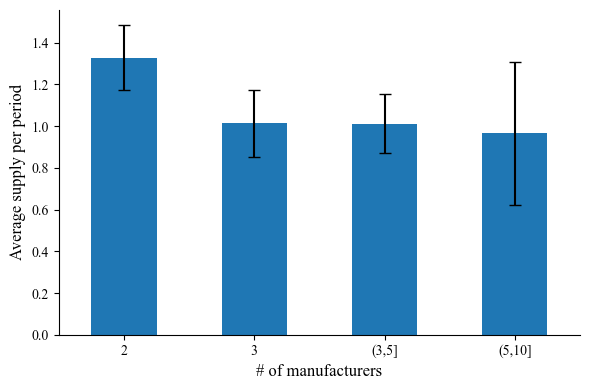

In [13]:
# Compute standard error
errors = mean_supply_by_bin["std"] / np.sqrt(mean_supply_by_bin["count"])

# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 4))

# Draw the bar chart with error bars
mean_supply_by_bin["mean"].plot.bar(
    ax=ax,
    yerr=errors,
    capsize=4,
    rot=0,
    
)

# Axis labels (bigger font for readability)
ax.set_xlabel("# of manufacturers", fontsize=12)
ax.set_ylabel("Average supply per period", fontsize=12)

# Tick label sizing
ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)

# Remove top & right spines for a cleaner look
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

# Add light horizontal gridlines
# ax.yaxis.grid(True, linestyle="--", linewidth=0.5)

# Tight layout to avoid clipping
plt.tight_layout()
plt.show()

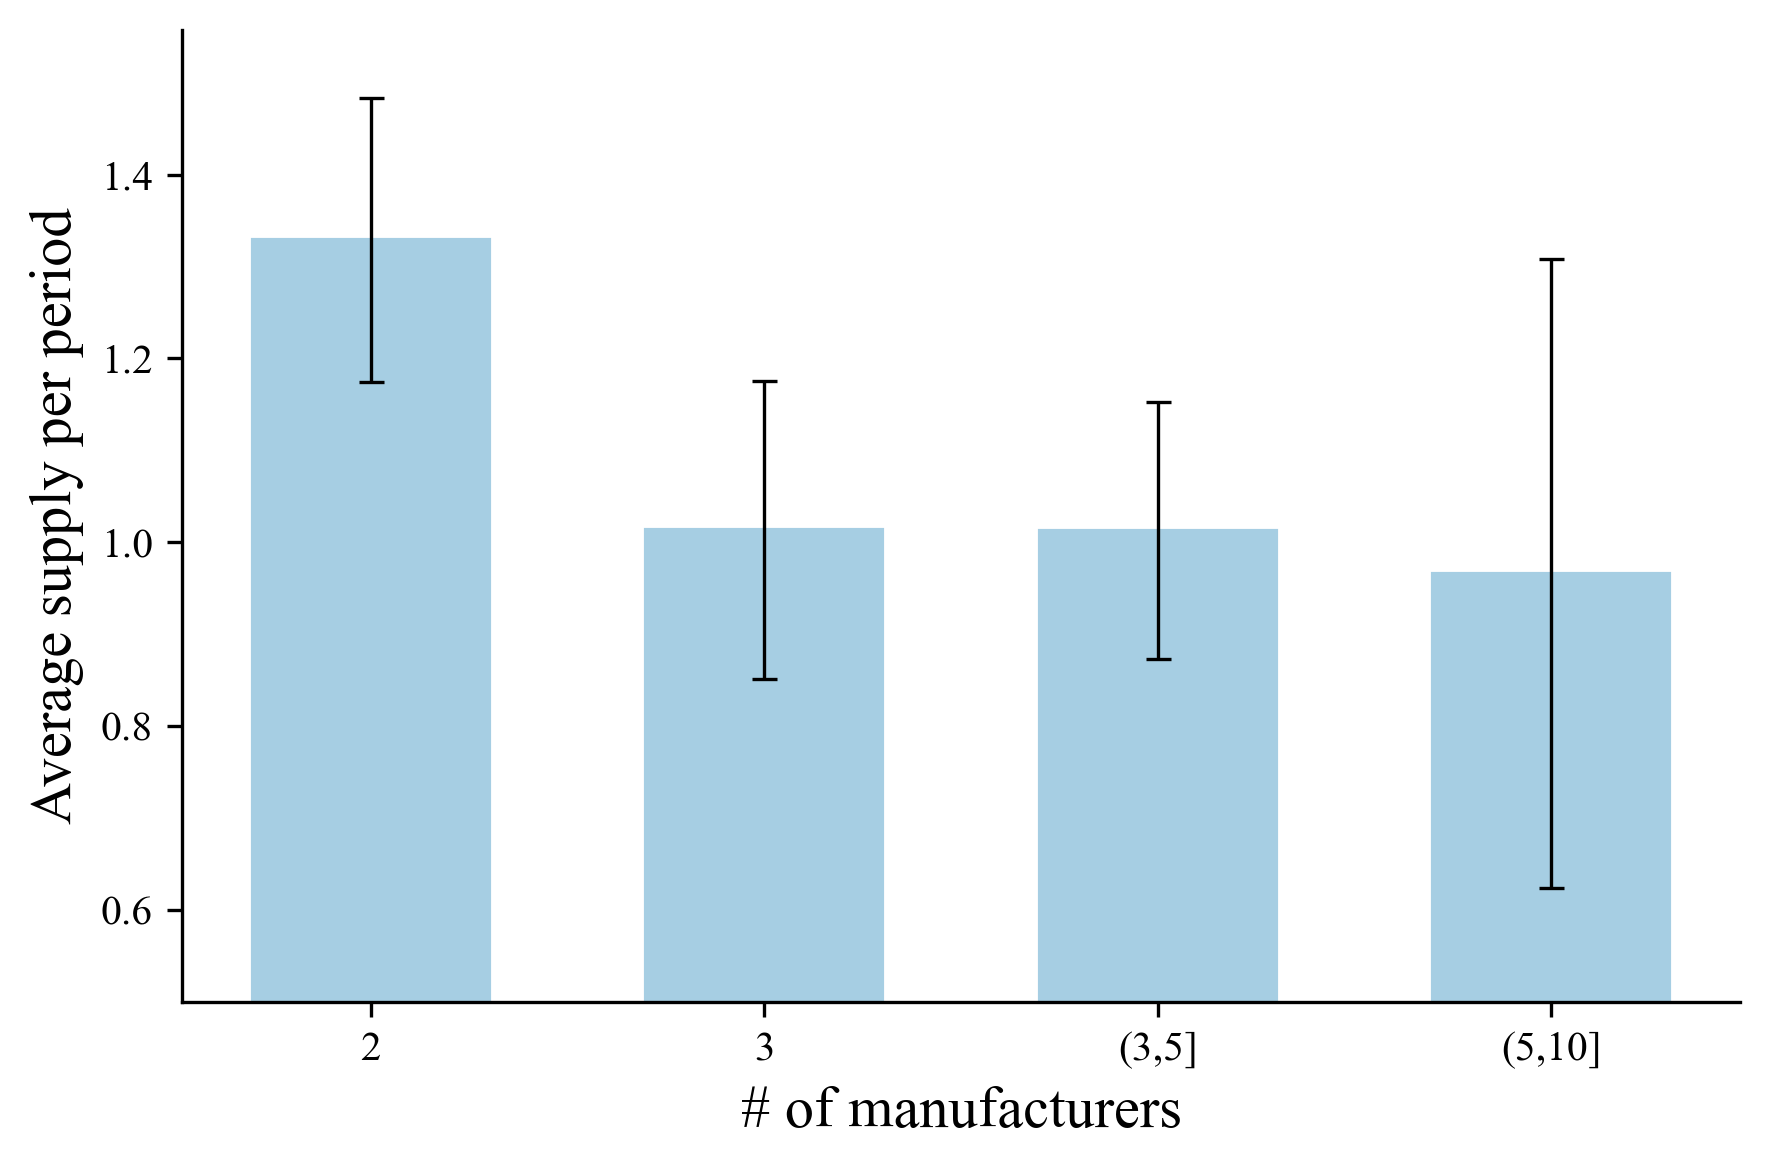

In [35]:
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors as mcolors

def darken(color, amount=1.3):
    c = mcolors.to_rgb(color)
    return mcolors.to_hex([min(1, x/amount) for x in c])

# ---------- Styling ----------
mpl.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],  # adjust if template differs
    "axes.labelsize": 14,
    "axes.titlesize": 14,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})

# Seaborn "colorblind" palette → choose the first colour for bars
BAR_COLOR  = sb.color_palette('Paired')[0]      # original light blue
EDGE_COLOR = darken(BAR_COLOR, 1.7)  
ERROR_KW   = dict(ecolor="black", lw=0.8, capsize=3, capthick=0.8)

# ---------- Plot ----------
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)

ax.bar(
    mean_supply_by_bin.index.astype(str),   # x positions
    mean_supply_by_bin["mean"],             # bar heights
    yerr=errors,                            # error bars
    color=BAR_COLOR,
    edgecolor=BAR_COLOR,
    width=0.60,
    error_kw=ERROR_KW,
)

ax.set_xlabel("# of manufacturers")
ax.set_ylabel("Average supply per period")
ax.set_ylim(bottom=0.5)

# Clean spines and add a subtle grid
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

# ax.yaxis.grid(True, linestyle="--", linewidth=0.5, alpha=0.4)

plt.tight_layout()
plt.show()



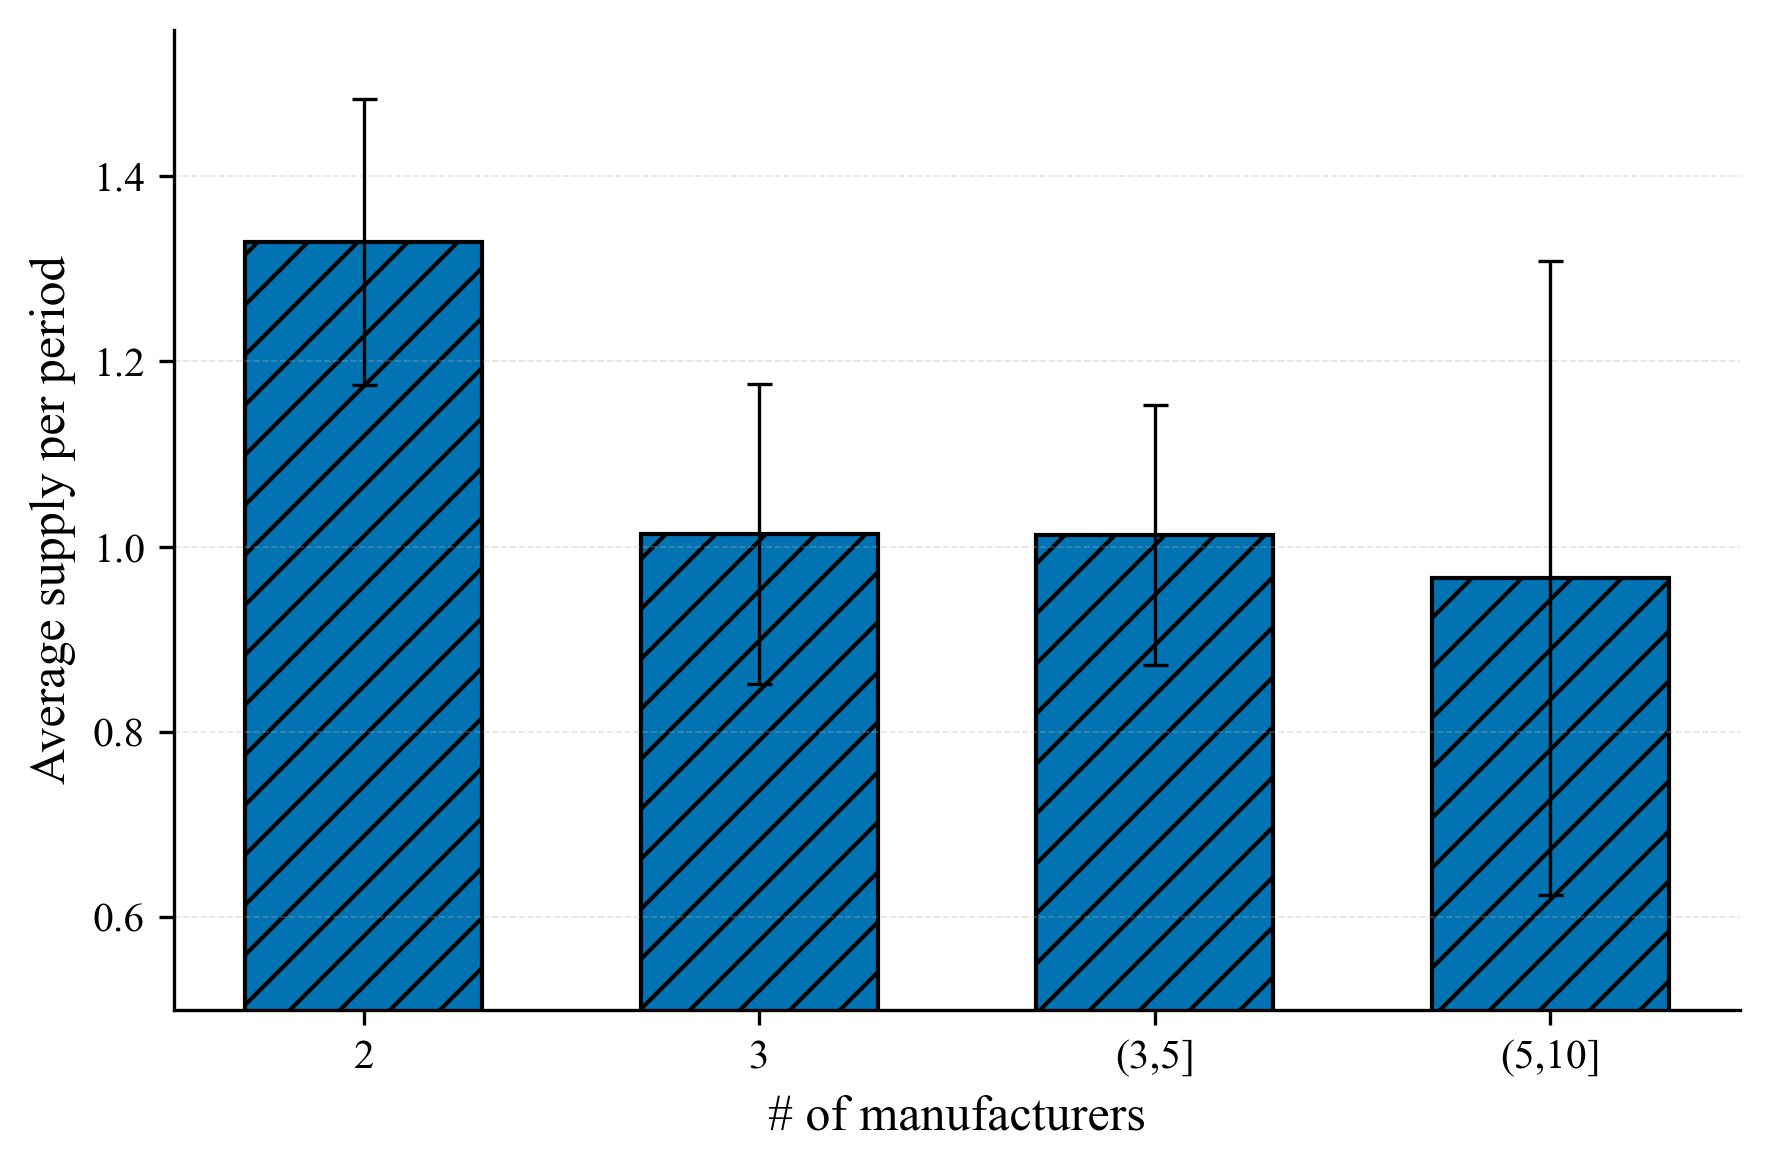

In [20]:
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib as mpl

# ---------- Styling ----------
mpl.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],  # adjust if template differs
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})

# Seaborn "colorblind" palette → choose the first colour for bars
BAR_COLOR  = sb.color_palette("colorblind")[0]   # a desaturated blue
EDGE_COLOR = "black"
ERROR_KW   = dict(ecolor="black", lw=0.8, capsize=3, capthick=0.8)

fig, ax = plt.subplots(figsize=(6, 4), dpi=300)

ax.bar(
    mean_supply_by_bin.index.astype(str),
    mean_supply_by_bin["mean"],
    yerr=errors,
    color=BAR_COLOR,
    edgecolor=EDGE_COLOR,
    width=0.60,
    error_kw=ERROR_KW,
    hatch="//",                 # diagonal hatch ensures visibility in grayscale
)

ax.set_xlabel("# of manufacturers")
ax.set_ylabel("Average supply per period")
ax.set_ylim(bottom=0.5)

for spine in ("top", "right"):
    ax.spines[spine].set_visible(False)

ax.yaxis.grid(True, linestyle="--", linewidth=0.4, alpha=0.35)

plt.tight_layout()
plt.show()

In [79]:
# extract all reasonings
from pathlib import Path

def find_decisions_files(simulation_ids, base_dir="experiments_logs"):
    """
    Returns a dict mapping each simulation_id to the Path of its decisions.csv file,
    or None if not found.
    """
    base = Path(base_dir)
    decisions_map = {}
    
    for sim_id in simulation_ids:
        # find the first directory ending with _<sim_id>
        match = next(
            (p for p in base.iterdir() if p.is_dir() and p.name.endswith(f"_{sim_id}")),
            None
        )
        if match is None:
            decisions_map[sim_id] = None
            continue
        
        csv_path = match / "decisions.csv"
        decisions_map[sim_id] = csv_path if csv_path.exists() else None
    
    return decisions_map


simulation_ids = df["simulation_id"].unique()
decisions_files = find_decisions_files(simulation_ids)

# Inspect:
decisions_list = []

for sim_id, csv_path in decisions_files.items():
    if csv_path:
        temp_df = pd.read_csv(csv_path)
        temp_df["simulation_id"] = sim_id
        decisions_list.append(temp_df)
    else:
        print(f"Warning: decisions.csv not found for simulation_id {sim_id}")

all_decisions_df = pd.concat(decisions_list, ignore_index=True)

# Now you have one DataFrame with every decisions.csv and a 'simulation_id' column
print(all_decisions_df.shape)
all_decisions_df.head()

(2518, 11)


,timestamp,simulation_id,period,event_type,event_data,agent_id,agent_type,decision_stage,llm_calls,reasoning,confidence
0,2025-07-30T17:28:33.341898,b5957c62,0,agent_decision,"{'context': {'period': 0, 'disrupted_manufactu...",fda_regulator,FDAAgent,collect_and_analyze,[],NaN,unknown
1,2025-07-30T17:28:36.229677,b5957c62,0,agent_decision,{'context': {'state_analysis': {'role': 'fda_r...,fda_regulator,FDAAgent,decide,[],"{""shortage_assessment"": ""Current status indica...",high
2,2025-07-30T17:28:39.512011,b5957c62,0,agent_decision,"{'context': {'period': 0, 'disrupted_manufactu...",manufacturer_0,ManufacturerAgent,collect_and_analyze,[],NaN,unknown
3,2025-07-30T17:28:46.091485,b5957c62,0,agent_decision,{'context': {'state_analysis': {'role': 'manuf...,manufacturer_0,ManufacturerAgent,decide,[],"{""market_analysis"": ""Current market conditions...",high
4,2025-07-30T17:28:48.634480,b5957c62,0,agent_decision,"{'context': {'period': 0, 'disrupted_manufactu...",manufacturer_1,ManufacturerAgent,collect_and_analyze,[],NaN,unknown


In [88]:
dec_df = all_decisions_df.loc[(all_decisions_df.agent_type == "ManufacturerAgent") & (all_decisions_df.decision_stage == "decide")]

In [92]:
import json
dec_df["reasoning_dict"] = dec_df["reasoning"].apply(json.loads)
reasoning_df = pd.concat([
    dec_df.drop(columns="reasoning_dict"),
    dec_df["reasoning_dict"].apply(pd.Series)
], axis=1)

/var/folders/33/gyvvd4710r7_4n22mnftfz4h0000gn/T/ipykernel_44835/847982187.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dec_df["reasoning_dict"] = dec_df["reasoning"].apply(json.loads)


In [98]:
full = reasoning_df.merge(
    df[["simulation_id","manufacturers"]],
    on="simulation_id",
    how="left"
)

In [99]:
grouped = full.groupby("manufacturers")

corpora = {
    field: grouped[field].apply(lambda texts: " ".join(texts.dropna()))
    for field in ["market_analysis","competitive_strategy",
                  "risk_assessment","financial_justification"]
}

/var/folders/33/gyvvd4710r7_4n22mnftfz4h0000gn/T/ipykernel_44835/1649865811.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = full.groupby("manufacturers")


In [101]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words="english", ngram_range=(1,2), max_features=50)
for field, series in corpora.items():
    X = cv.fit_transform(series)
    freqs = pd.DataFrame(
        X.toarray(), 
        index=series.index, 
        columns=cv.get_feature_names_out()
    )
    print(f"\nTop terms in '{field}':")
    display(freqs.T.sort_values(by=series.index[0], ascending=False).head(10))


Top terms in 'market_analysis':


manufacturers,2,3,"(3,5]","(5,10]"
demand,206,183,383,240
shortage,150,145,284,190
risk,125,124,238,141
shortage risk,122,122,234,139
stable,112,125,230,145
current,107,108,187,111
market,100,111,206,132
competitor,87,81,145,95
capacity,77,75,143,84
conditions,74,88,128,90



Top terms in 'competitive_strategy':


manufacturers,2,3,"(3,5]","(5,10]"
capacity,157,166,315,200
current,134,133,247,163
maintaining,126,132,244,151
current capacity,120,126,227,151
maintaining current,117,125,228,145
market,82,63,144,97
competitors,74,78,135,92
competitor,56,52,83,56
unnecessary,55,61,125,71
demand,55,46,125,59



Top terms in 'risk_assessment':


manufacturers,2,3,"(3,5]","(5,10]"
risk,160,158,299,203
demand,136,130,232,131
main,103,107,205,120
capacity,75,65,114,84
main risk,68,72,136,90
potential,67,60,132,86
risks,62,52,114,57
competitor,61,68,125,68
current,56,48,103,64
expansion,42,32,86,50



Top terms in 'financial_justification':


manufacturers,2,3,"(3,5]","(5,10]"
demand,132,141,263,175
investment,118,126,239,162
cost,82,88,171,111
expansion,81,67,131,87
roi,78,81,183,84
capacity,77,64,152,81
stable,62,75,144,90
current,61,74,123,87
investment cost,56,64,124,85
given,52,67,121,81


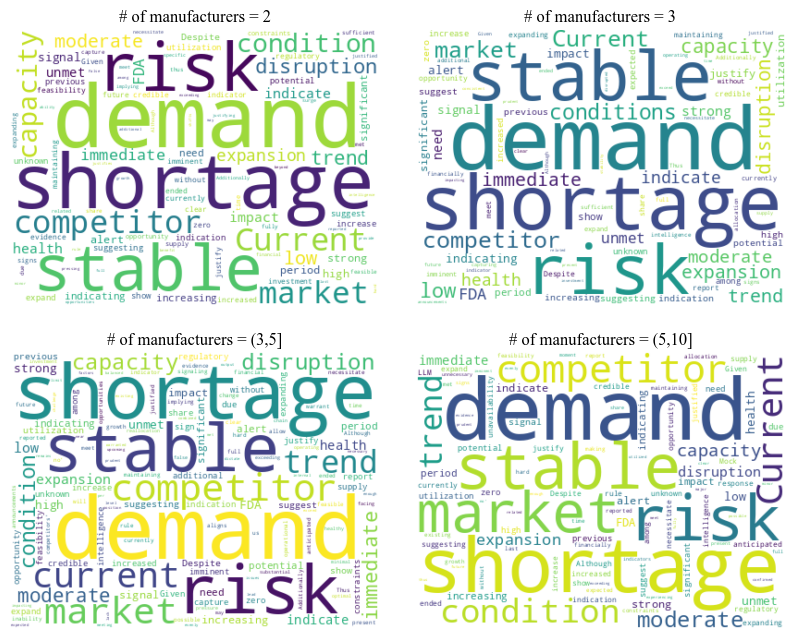

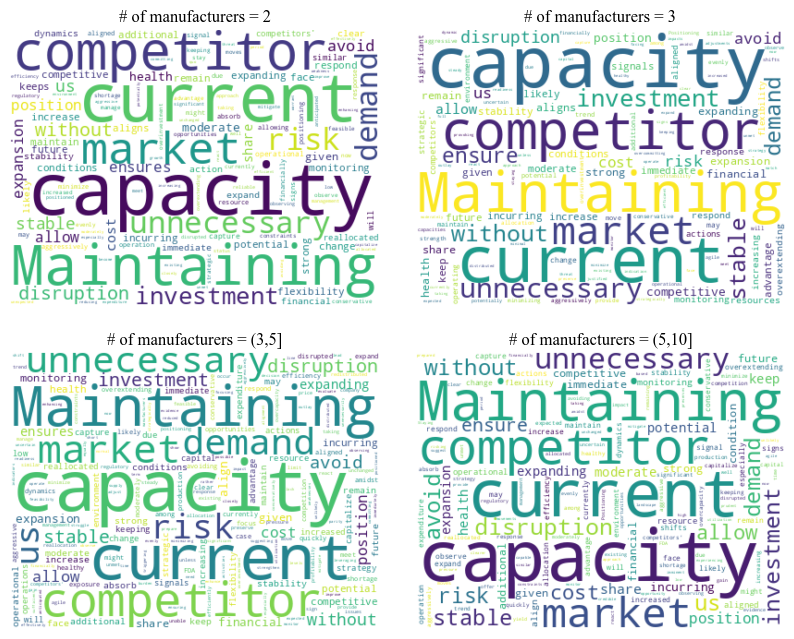

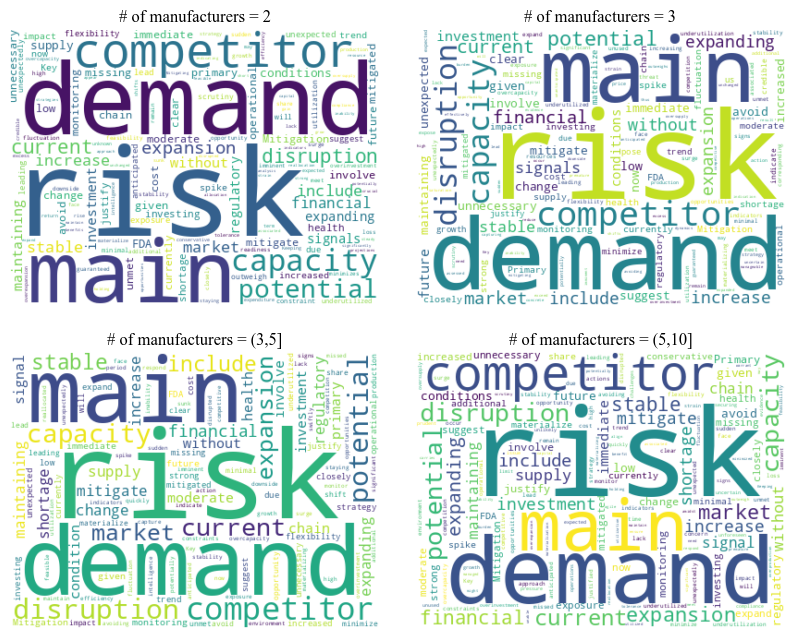

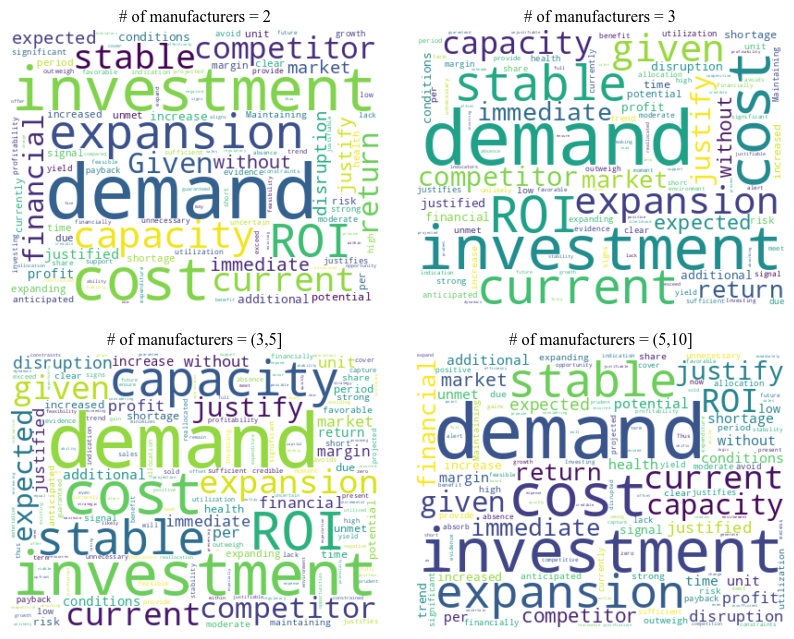

In [119]:
for field, series in corpora.items():
    n_bins = len(series)
    n_cols = 2
    n_rows = (n_bins + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
    axes = axes.flatten()

    for ax, (bin_label, text) in zip(axes, series.items()):
        wc = WordCloud(
            width=400,
            height=300,
            background_color='white',
            collocations=False
        ).generate(text)
        ax.imshow(wc, interpolation='bilinear')
        ax.set_title(f"# of manufacturers = {bin_label}", fontsize=12)
        ax.axis('off')

    # Hide any extra axes
    for ax in axes[n_bins:]:
        ax.axis('off')

    # Increase spacing between subplots
    fig.subplots_adjust(wspace=0.1, hspace=0.1)

    plt.show()